In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import sys
import datetime
import logging

print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
print('Python version ' + sys.version)
print('Numpy version ' + np.version.version)
print('Pandas version ' + pd.__version__)
print('MatplotLib version ' + matplotlib.__version__)
print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=')
logging.info('Program start.')

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Python version 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Numpy version 1.16.2
Pandas version 0.24.2
MatplotLib version 3.0.3
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [95]:
# Hardcoded filepath for testing and dev purposes
file = 'latest.txt'

# Initialize the data array
data = pd.DataFrame(dtype=float)

temp1 = []
temp2 = []
temp3 = []
with open(file) as f:
    for line in f.readlines():
        # If it's a line with eco stat data (they are all flagged)
        if 'ECOSTATS' in line:
            # Cut off the preceding bits we dont care about
            cache1 = line.split(sep='ECOSTATS: ,')[1]
            temp1.append(cache1.split(sep=','))
        elif 'BUILDINGSTATS:' in line:
            cache2 = line.split(sep='BUILDINGSTATS: ,')[1]
            temp2.append(cache2.split(sep=','))
        elif 'UNITSTATUS:' in line:
            cache3 = line.split(sep='UNITSTATUS: ,')[1]
            temp3.append(cache3.split(sep=','))
            
            
            
            
ecodat = data.append(temp1)
ecodat.columns=['Time', 'Team',
              'Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod', 'Gold_Prod', 'Diamond_Prod', 'Emerald_Prod',
              'Food', 'Lumber', 'Stone', 'Iron', 'Gold', 'Diamonds', 'Emeralds'
             ]


ecodat.Time = pd.to_datetime(ecodat.Time)
ecodat.Team = ecodat.Team.astype(str)
ecodat[['Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod']] = ecodat[['Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod']].astype(int)
ecodat[['Gold_Prod', 'Diamond_Prod', 'Emerald_Prod']] = ecodat[['Gold_Prod', 'Diamond_Prod', 'Emerald_Prod']].astype(int)
ecodat[['Food', 'Lumber', 'Stone', 'Iron']] = ecodat[['Food', 'Lumber', 'Stone', 'Iron']].astype(int)
ecodat[['Gold', 'Diamonds', 'Emeralds']] = ecodat[['Gold', 'Diamonds', 'Emeralds']].astype(int)
logging.info('Econ: \n{}'.format(ecodat.dtypes))

builddat = data.append(temp2)
builddat.columns = ['Timestamp', 'Team', 'Archery Range' , 'Armory' , 'Barracks' , 'Farms' , 'Gates' , 'LumberYard' ,
                    'Diamond Mine' , 'Emerald Mine' ,  'Gold Mine' , 'Iron Mine' ,  'Stone Mine' ,
                    'ResearchCenter' , 'Siege Workshop' , 'Stables' , 'TownHalls' , 'Walls' , 'Wallsteps' , 'Watchtowers']
logging.info('Buildings: \n{}'.format(builddat.dtypes))


unitdat = data.append(temp3)
unitdat.columns = ['Time', 'Team', 'Minion', 'Archer', 'Lancer', 'Pikeman', 'Trebuchet']

unitdat.Time = pd.to_datetime(unitdat.Time)
unitdat.Team = unitdat.Team.astype(str)
unitdat[['Minion', 'Archer', 'Lancer', 'Pikeman', 'Trebuchet']] = unitdat[['Minion', 'Archer', 'Lancer', 'Pikeman', 'Trebuchet']].astype(int)
logging.info('Troops: \n{}'.format(ecodat.dtypes))

IndexError: list index out of range

In [84]:
def wasInMatch(df, team):
    '''
    This function checks the eco dataframe provided, and returns a boolean of whether the provided team,
    was or was not playing.
    '''
    # Copy the data for this team only
    df = df.loc[df.Team == team].copy()
    
    if df.Food_Prod.sum() == 0:
        return False
    else:
        return True
    
    

def teamResourcePlot(df, team='red', p=True):
    '''
    Creates a resource plot for a team. Valid team names are: red, blue, green, yellow.
    If p is True include production rates for all resources on the plot.
    
    Returns a matplotlib figure and axes and plots the figure.
    '''
    # Copy the data for this team only
    df = df.loc[df.Team == team].copy()
    
    # Drop the uninteresting bits.
    # For now, start plotting after the townhall is placed (when production initializes)
    # The townhall generates some food, so as long as it is positive, the team is still in play.
    df = df.loc[df.Food >= 0].copy()
    
    # Set time to be index for automatic plots crossed with time
    df.set_index(df.Time, inplace=True)
    
    if p:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(19,14) )
        ax1 = df.plot(ax=axes[0], y=['Food', 'Lumber', 'Stone', 'Iron', 'Gold'], color=['orange', 'g', 'k', 'grey', 'gold'])
        ax2 = df.plot(ax=axes[1], y=['Food_Prod', 'Lumber_Prod', 'Stone_Prod', 'Iron_Prod', 'Gold_Prod'], color=['orange', 'g', 'k', 'grey', 'gold'], style=':')
        
        ax1.set_title('{} Team Resources\n'.format(team.title()), fontsize=24)
        ax1.set_xlabel(None)
        
        ax1.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
        ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
        
        ax1.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
        ax2.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
        
        ax2.set_title('Production Rates')

    else:
        ax1 = df.plot(y=['Food', 'Lumber', 'Stone', 'Iron', 'Gold'], figsize=(19,7), title='{} Team Resources'.format(team.title()))
        fig = ax1.get_figure()
    
    return fig, ax1


def ecoIndexPlot(df, w=[1, 1.2, 0.7, 0.85, 1.35]):
    '''
    This function creates a plot representing the Economic Power of each team during the match.
    The economic index is calculated as the sum of each resource production, times its stored amount, times its weight.
    The sum is then divided a factor for ease of plotting.
    
    Returns a matplotlib figure and axes, and plots the figure. 
    '''
    df['Econ'] = (w[0]*df.Food_Prod*df.Food + w[1]*df.Lumber_Prod*df.Lumber + w[2]*df.Stone_Prod*df.Stone + w[3]*df.Iron_Prod*df.Iron + w[4]*df.Gold_Prod*df.Gold)/(5000*len(w))
    df.set_index(df.Time, inplace=True)
    # Trim the df before the townhall is placed.
    df = df.loc[df.Food_Prod >= 5].copy()

    # initiate the plot
    fig, ax = plt.subplots(figsize=(19,7))

    # group the df by team, and add each one to the axes with the appropriate color
    for name, group in df.groupby(df.Team):
        group.Econ.plot(ax=ax, color=name[:1],label=name)


    ax.legend()
    ax.set_title('Economic Power', fontsize=24)
    ax.text(0.005, 0.95, s='weights={}'.format(w), transform=ax.transAxes)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
    plt.show()
    
    return fig, ax


def teamTroopPlot(df, team='red'):
    '''
    Creates a troop plot for a team. Valid team names are: red, blue, green, yellow.
    
    Returns a matplotlib figure and axes, and plots the figure.
    '''
    # Copy the data for this team only
    df = df.loc[df.Team == team].copy()
    # Set time to be index for automatic plots crossed with time
    df.set_index(df.Time, inplace=True)
    
    fig, ax = plt.subplots(figsize=(19,7))
    ax = df.plot(ax=ax, y=['Minion', 'Archer', 'Lancer', 'Pikeman', 'Trebuchet'], color=['brown', 'red', 'g', 'k', 'gold'])
    
    ax.set_title('{} Team Troops\n'.format(team.title()), fontsize=24)
    ax.set_xlabel(None)

    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
    
    return fig, ax


def troopIndexPlot(df, w=[1, 1, 1, 1, 0]):
    '''
    This function creates a plot representing the Military Power of each team during the match.
    The military power is calculated as the sum of 
    '''
     # Copy the data for this team only
    df['Power'] = w[0]*df.Minion + w[1]*df.Archer + w[2]*df.Lancer + w[3]*df.Pikeman + w[4]*df.Trebuchet
    df.set_index(df.Time, inplace=True)

    # initiate the plot
    fig, ax = plt.subplots(figsize=(19,7))

    # group the df by team, and add each one to the axes with the appropriate color
    for name, group in df.groupby(df.Team):
        group.Power.plot(ax=ax, color=name[:1], label=name)


    ax.legend()
    ax.set_title('Military Power', fontsize=24)
    ax.text(0.005, 0.95, s='weights={}'.format(w), transform=ax.transAxes)
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.003))
    ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.0003))
    plt.show()
    
    return fig, ax

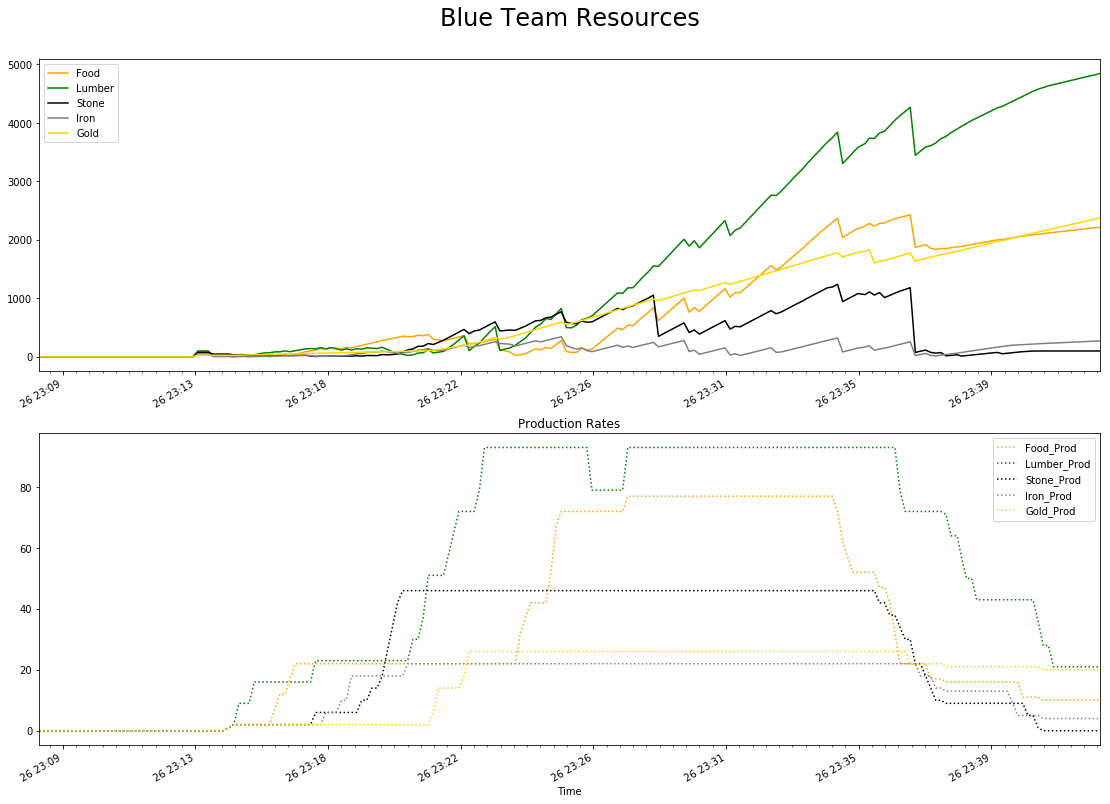

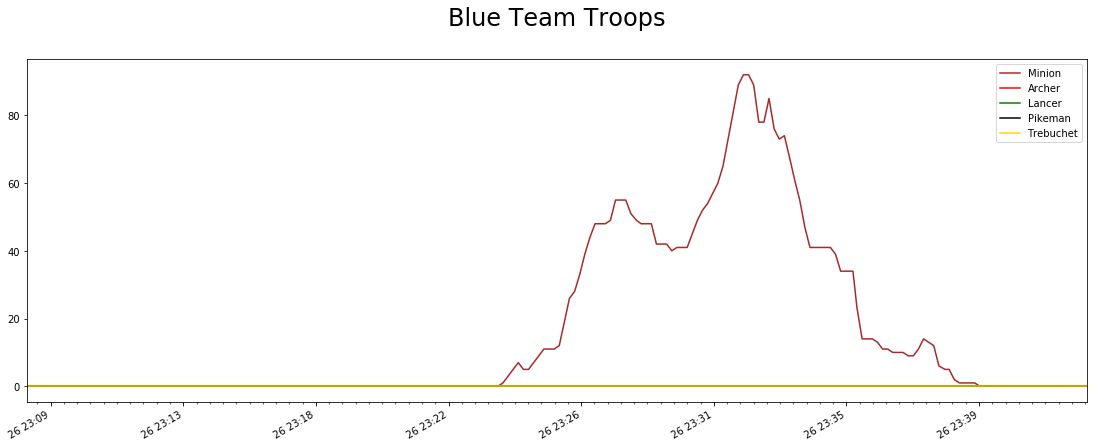

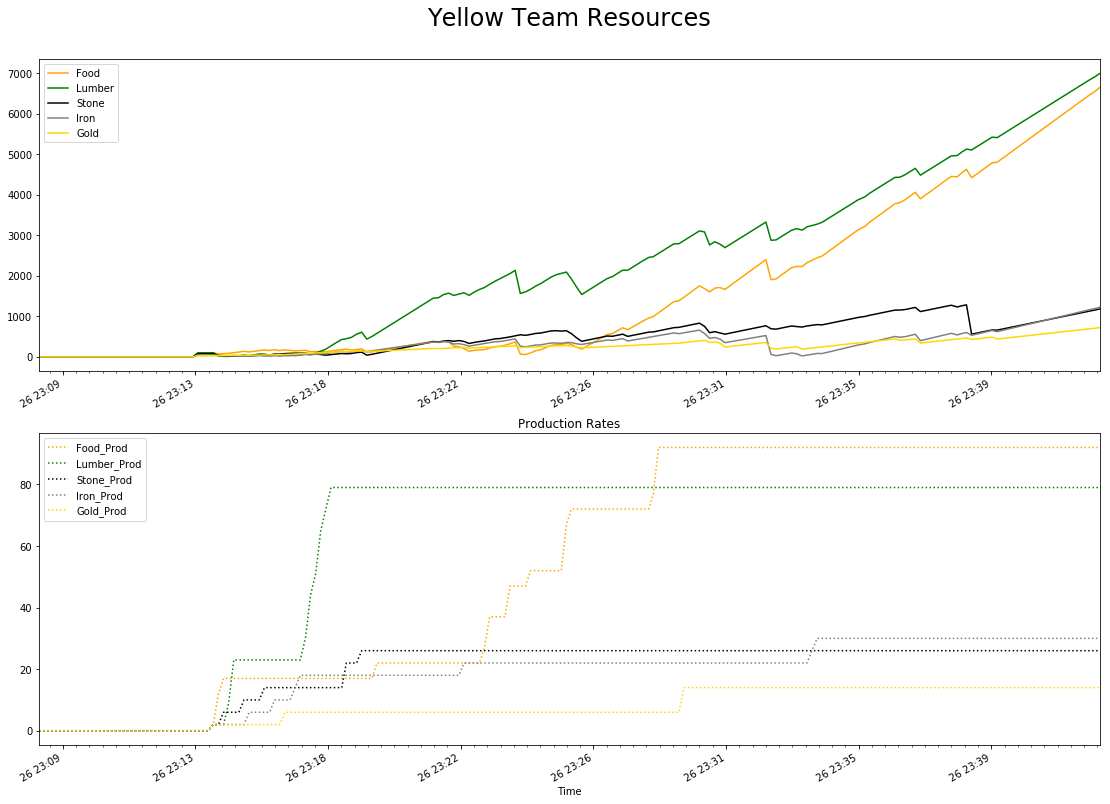

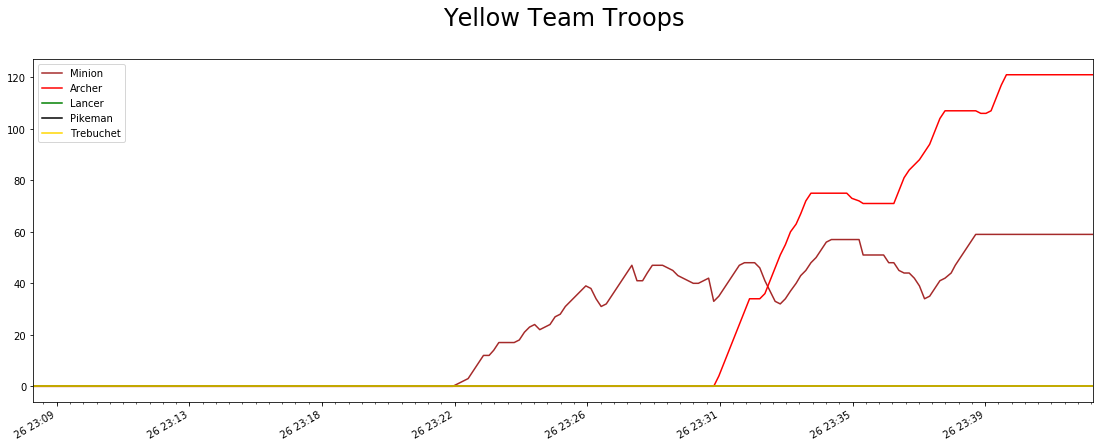

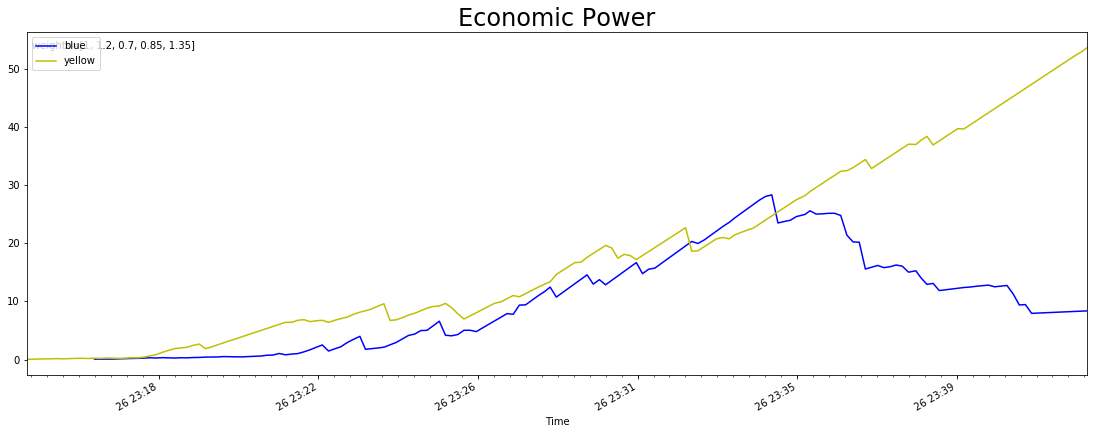

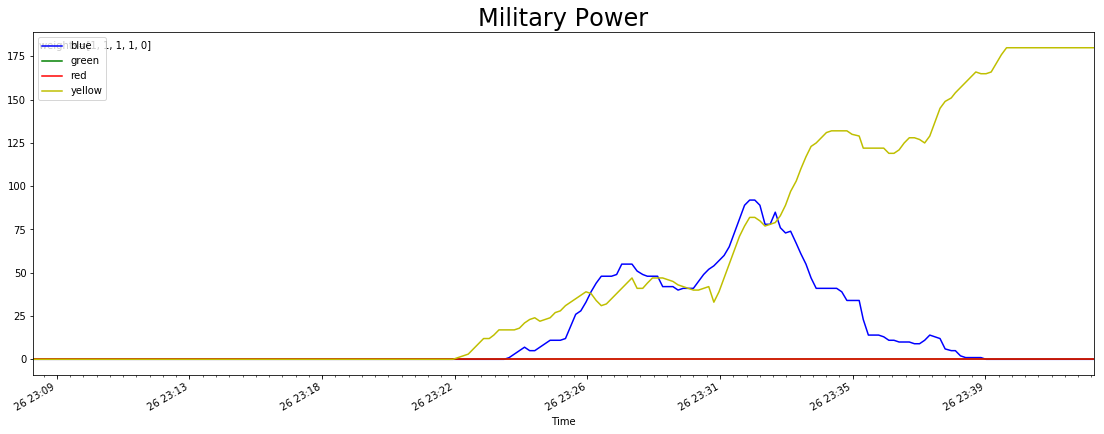

In [90]:
for team in ['red', 'blue', 'yellow', 'green']:
    if wasInMatch(ecodat, team):
        fig, ax = teamResourcePlot(ecodat, team=team, p=True)
        fig.savefig('.\out\{} Resources.png'.format(team))

        fig, ax = teamTroopPlot(unitdat, team=team)
        fig.savefig('.\out\{} Troops.png'.format(team))

    
fig, ax = ecoIndexPlot(ecodat)
fig.savefig('.\out\Econ Summary.png')

fig, ax = troopIndexPlot(unitdat)
fig.savefig('.\out\Military Summary.png')